In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#sns.set(style="whitegrid") 
#plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)

In [2]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

0.23.2


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import shap
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix,classification_report, roc_curve, precision_recall_curve, roc_auc_score, accuracy_score 
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline


In [5]:
df_train = pd.read_csv('C:/Users/ABHAYA/train_data_custom_0101.csv',low_memory = False).iloc[:,1:]
df_test = pd.read_csv('C:/Users/ABHAYA/test_data_custom_0101.csv',low_memory = False).iloc[:,1:]

In [6]:
df_train.shape,df_test.shape

((598978, 40), (256991, 40))

In [7]:
df_test.drop(columns=["home_ownership","initial_list_status"],inplace=True)
df_train.drop(columns=["home_ownership","initial_list_status"],inplace=True)

In [61]:
target_col = 'default_ind'

#feature space
X_train = df_train.drop(columns=[target_col])


#target variable
y_train = df_train[target_col]


In [62]:
#feature space
X_test = df_test.drop(columns=[target_col])


#target variable
y_test = df_test[target_col]

In [63]:
X_train.shape,y_train.shape

((598978, 37), (598978,))

In [64]:
y_train.value_counts()

0    552822
1     46156
Name: default_ind, dtype: int64

In [65]:
X_test.shape, y_test.shape

((256991, 37), (256991,))

In [66]:
drop_cols=["int_rate","grade","purpose","total_rec_prncp","collections_12_mths_ex_med","credit_line_ratio"]

X_train.drop(columns=drop_cols,inplace=True)
X_test.drop(columns=drop_cols,inplace=True)

In [67]:
X_train.shape,X_test.shape

((598978, 31), (256991, 31))

### Scaling Train and Test Data

In [68]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_train_sc=pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
X_train_sc.head(3)

funded_amnt  term  sub_grade  emp_length  annual_inc  title   dti  delinq_2yrs  inq_last_6mths  mths_since_last_delinq  revol_bal  revol_util  out_prncp  total_pymnt  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  mths_since_last_major_derog  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  due_time  credit_hist  home_ownership_MORTGAGE  \
0        -1.14 -0.63       0.76        1.13       -0.88  -0.99  1.24        -0.36            0.27                   -0.71      -0.14        1.17      -0.81        -0.52          -0.62               -0.10       -0.14                    -0.09            -0.49                        -0.47         -0.02        -0.82             -0.77     -0.96         1.46                    -1.01   
1        -1.44  1.58      -0.32       -1.52       -0.77   2.25 -2.06        -0.36            4.27                   -0.71      -0.71       -1.95      -0.81        -1.12          -0.81               -0.10        0.10                    -0.08            -0.50                        -0.47         -0.02        -0.82             -0.77     -0.96        -0.47                    -1.01   
2        -1.46 -0.63      -0.47        1.13       -1.09   3.10 -1.11        -0.36            1.27                   -0.71      -0.65        1.80      -0.81        -0.87          -0.74               -0.10       -0.14                    -0.09            -0.40                        -0.47         -0.02        -0.82             -0.77     -0.96        -0.82                    -1.01   

   home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  home_ownership_RENT  initial_list_status_w  
0                -0.01                 -0.02               -0.32                 1.22                  -0.81  
1                -0.01                 -0.02               -0.32                 1.22                  -0.81  
2                -0.01                 -0.02               -0.32                 1.22                  -0.81

In [69]:
X_test_sc=pd.DataFrame(sc.transform(X_test),columns=X_test.columns)
X_test_sc.head(3)

funded_amnt  term  sub_grade  emp_length  annual_inc  title   dti  delinq_2yrs  inq_last_6mths  mths_since_last_delinq  revol_bal  revol_util  out_prncp  total_pymnt  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  mths_since_last_major_derog  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  due_time  credit_hist  home_ownership_MORTGAGE  \
0         1.26 -0.63       1.69       -1.25        1.34  -0.65 -1.00        -0.36           -0.73                   -0.71       0.14       -0.56       2.51        -1.16          -0.98               -0.10       -0.14                    -0.09            -0.39                        -0.47         -0.02         2.05              0.50      0.48         0.50                     0.99   
1         0.42  1.58      -1.55        0.34        1.34  -0.37 -1.02        -0.36            0.27                   -0.71      -0.12       -0.64       1.62        -1.21          -0.95               -0.10       -0.14                    -0.09            -0.46                        -0.47         -0.01        -0.58              0.19      0.48        -0.77                    -1.01   
2        -0.90 -0.63       1.23        1.13       -0.26  -0.65 -0.57         0.85            0.27                    0.30      -0.29       -1.33       0.14        -1.24          -1.00               -0.10       -0.14                    -0.09            -0.52                        -0.47         -0.02        -0.45              0.44     -0.96         0.41                     0.99   

   home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  home_ownership_RENT  initial_list_status_w  
0                -0.01                 -0.02               -0.32                -0.82                   1.24  
1                -0.01                 -0.02               -0.32                 1.22                   1.24  
2                -0.01                 -0.02               -0.32                -0.82                   1.24

In [70]:
y_train.shape,y_test.shape

((598978,), (256991,))

In [71]:
y_train_sc=y_train.copy()
y_test_sc=y_test.copy()

y_train_sc.shape,y_test_sc.shape

((598978,), (256991,))

### SMOTE on Train Data

In [72]:
sm = SMOTE(random_state=42)

In [73]:
X_train_sc.shape,y_train_sc.shape

((598978, 31), (598978,))

In [74]:
X_train, y_train = sm.fit_sample(X_train, y_train)

In [75]:
X_train_sc, y_train_sc = sm.fit_sample(X_train_sc, y_train_sc)

In [60]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfpvalue= pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfpvalue,dfscores],axis=1)
featureScores.columns = ['Specs','pvalue','Score']  #naming the dataframe columns
print(featureScores.nlargest(35,'Score'))  #print features

                          Specs  pvalue         Score
21                  tot_cur_bal    0.00 3511738751.59
12                    out_prncp    0.00 3196580674.06
18              last_pymnt_amnt    0.00 1053950324.79
22             total_rev_hi_lim    0.00  702533265.90
13                  total_pymnt    0.00  556362523.20
16                   recoveries    0.00  469600894.99
4                    annual_inc    0.00  390677885.21
5                         title    0.00  183677441.68
10                    revol_bal    0.00   50765782.71
17      collection_recovery_fee    0.00   48135591.28
20                 tot_coll_amt    0.00   24197654.43
24                  credit_hist    0.00   17725143.81
23                     due_time    0.00    7500097.40
14                total_rec_int    0.00    2666180.84
15           total_rec_late_fee    0.00     939878.60
2                     sub_grade    0.00     204475.85
0                   funded_amnt    0.00     103837.38
19  mths_since_last_major_de

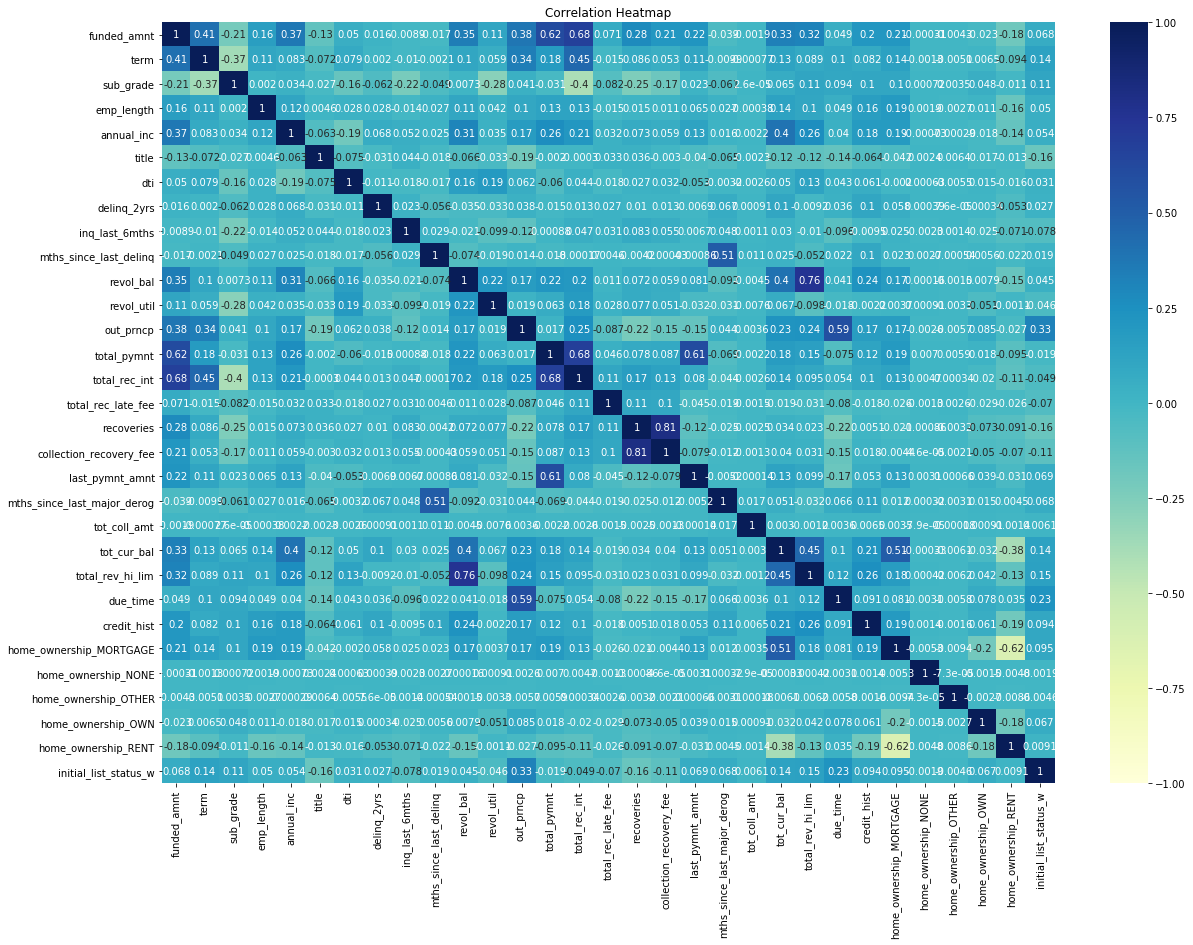

In [76]:
#heat map for identifying multi-colinearit

corr_tab=X_train.corr()
fit,ax = plt.subplots(figsize=(20,14))
sns.heatmap(corr_tab,vmin=-1.0,vmax=1.0,annot=True, cmap="YlGnBu")
ax.set_ylim(len(corr_tab), 0.0)
plt.title("Correlation Heatmap")
plt.show()

In [100]:
X_train.columns

Index(['funded_amnt', 'term', 'sub_grade', 'emp_length', 'annual_inc', 'title', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'revol_bal', 'revol_util', 'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'due_time',
       'credit_hist', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'initial_list_status_w'],
      dtype='object')

In [77]:
#ROC dict for TPR and FPR values 
roc_dict = {}

#precision recall curve
prc_dict = {}


def modify_roc_dict(clf, y_test, x_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(x_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
    
def modify_prc_dict(clf, y_test, x_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(x_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

#### RANDOMFOREST

In [86]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=42)
model_rf = rf.fit(X_train, y_train)
predictions = model_rf.predict(X_test)

In [87]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256680
           1       0.91      0.97      0.94       311

    accuracy                           1.00    256991
   macro avg       0.95      0.98      0.97    256991
weighted avg       1.00      1.00      1.00    256991



In [88]:
plot_confusion_matrix(model_rf, X_test, y_test)  # doctest: +SKIP
plt.show()

In [89]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [90]:
modify_prc_dict(clf=rf,
                y_test=y_test,
               x_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

In [97]:
auc = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1])
print('AUC: %.3f' % auc)

AUC: 0.995


#### XGB CLASSIFIER

In [91]:
xgb_clf = xgb.XGBClassifier(n_estimators=100,n_jobs=-1,random_state=42)
model_xgb = xgb_clf.fit(X_train, y_train)
predictions = model_xgb.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256680
           1       0.75      0.97      0.84       311

    accuracy                           1.00    256991
   macro avg       0.87      0.98      0.92    256991
weighted avg       1.00      1.00      1.00    256991



In [92]:
plot_confusion_matrix(model_xgb, X_test, y_test)  # doctest: +SKIP
plt.show()

In [93]:
#metrics for xgb
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [94]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                x_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [96]:
auc = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:,1])
print('AUC: %.3f' % auc)

AUC: 0.993
